# **POLI170A Project**

Research question: Does increased availability of on-sale alcohol, specifically Type 41 (On-Sale Beer and Wine – Public) and Type 47 (On-Sale General – Eating), lead to higher rates of crime, such as assault or robbery, in communities in San Diego County?

# Setup

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.stats.outliers_influence import variance_inflation_factor

def standardize(X):
    return (X - X.mean()) / X.std()

In [2]:
zipcode_df = pd.read_csv("zipcode.csv", header = None)
zipcode_arr = zipcode_df[0].values

# Alcohol Dataset

Records of alcohol licenses in california, from the CA ABC daily file, with improvements to geographic identifiers, and acompilation of areal densities of on-sale and off-sale licenses in San Diego county.

* ca_abc_licenses. California Alcohol Beverage Control License records
* sd_abc_density. Areal density of on-sale and off-sale licenses in San Diego county

In [3]:
# most update dataset from website
ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)

# sd_abc_density_df =  pd.read_csv('http://library.metatab.org/abc.ca.gov-licenses-2.1.2/data/sd_abc_density.csv')

/tmp/ipykernel_1843/1685933328.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)


Briefly browse dataset

In [4]:
ca_licenses.head(3)

,License Type,File Number,Lic or App,Type Status,Type Orig Iss Date,Expir Date,Fee Codes,Dup Counts,Master Ind,Term in # of Months,...,Prem State,Prem Zip,DBA Name,Mail Addr 1,Mail Addr 2,Mail City,Mail State,Mail Zip,Prem County,Prem Census Tract #
0,77,561256,LIC,ACTIVE,01-DEC-2015,30-NOV-2024,P40,001,N,12,...,CA,91762-3644,FIREWATER BAR,,,,,,SAN BERNARDINO,0010.02
1,48,526584,LIC,ACTIVE,08-JAN-2013,31-DEC-2024,P40,001,N,12,...,CA,94578-2815,CLUB CALIENTE,PO BOX 3541,,SAN LEANDRO,CA,94578-0541,ALAMEDA,4331.03
2,77,518989,LIC,ACTIVE,21-JUN-2012,31-MAY-2024,P40,001,N,12,...,CA,93001-2826,BARRELHOUSE 101,,,,,,VENTURA,0024.00


In [5]:
ca_licenses.columns

Index(['License Type', 'File Number', 'Lic or App', 'Type Status',
       'Type Orig Iss Date', 'Expir Date', 'Fee Codes', 'Dup Counts',
       'Master Ind', 'Term in # of Months', 'Geo Code', 'District',
       'Primary Name', 'Prem Addr 1', ' Prem Addr 2', 'Prem City',
       ' Prem State', 'Prem Zip', 'DBA Name', 'Mail Addr 1', 'Mail Addr 2',
       'Mail City', 'Mail State', 'Mail Zip', 'Prem County',
       'Prem Census Tract #'],
      dtype='object')

## Data Cleaning

1. dealing with license issue date, expire date

In [6]:
# drop rows with NaN values in 'Type Orig Iss Date' and 'Expir Date'
ca_licenses['Type Orig Iss Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses['Expir Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses.dropna(subset=['Type Orig Iss Date', 'Expir Date'], inplace=True)

# convert to datatime
ca_licenses['Type Orig Iss Date'] = pd.to_datetime(ca_licenses['Type Orig Iss Date'], format='%d-%b-%Y')
ca_licenses['Expir Date'] = pd.to_datetime(ca_licenses['Expir Date'], format='%d-%b-%Y')

2. transform all zipcode into 5-digits format

In [7]:
ca_licenses['Prem Zip'] = ca_licenses['Prem Zip'].str.slice(0, 5)

3. filter the dataframe based on the following conditions:
  * Is an active License (Lic) not an Application (App) that is still being processed
  * issue date before 2016-01-01
  * expire date after 2020-07-31
  * license is active
  * license type is 41, 47, or **48**?
  (41; On-Sale Beer and Wine – Public, 47: On-Sale General – Eating, 48: On-Sale General — Public ( Bars and Nightclubs ))
  * license is used within San Diego

In [8]:
df_alcohol = ca_licenses[
    (ca_licenses['Lic or App'] == 'LIC') &
    (ca_licenses['Type Orig Iss Date'] < '2016-01-01') &
    (ca_licenses['Expir Date'] > '2020-07-31') &
    (ca_licenses['Type Status'] == 'ACTIVE') &
    ((ca_licenses['License Type'] == 47) | (ca_licenses['License Type'] == 41)) &
    (ca_licenses['Prem County'] == "SAN DIEGO")
].reset_index(drop = True)

4. select important features <br>

In [9]:
sub_alcohol = df_alcohol[['Type Orig Iss Date', 'Expir Date', 'DBA Name', 'Prem Addr 1', 'Prem City', 'Prem Zip']]
sub_alcohol.head(5)

,Type Orig Iss Date,Expir Date,DBA Name,Prem Addr 1,Prem City,Prem Zip
0,2013-01-16,2024-12-31,LAUBERGE DEL MAR,1540 CAMINO DEL MAR,DEL MAR,92014
1,1993-12-31,2024-11-30,CATAMARAN RESORT HOTEL,3999 MISSION BLVD,SAN DIEGO,92109
2,2012-01-12,2024-12-31,MANCHESTER GRAND HYATT SAN DIEGO,ONE MARKET PLACE,SAN DIEGO,92101
3,2012-01-19,2024-12-31,BARLEY MASH,600 5TH AVE,SAN DIEGO,92101
4,2012-11-30,2024-12-31,BEAUDEVIN,3707 N HARBOR DR,SAN DIEGO,92101


In [10]:
sub_alcohol.shape

(1500, 6)

## EDA

Count the number of licenses based on cities in San Diego

In [11]:
sub_alcohol['Prem City'].unique()

array(['DEL MAR', 'SAN DIEGO', 'LA MESA', 'ESCONDIDO', 'RAMONA', 'POWAY',
       'CARLSBAD', 'LA JOLLA', 'ENCINITAS', 'SANTEE', 'OCEANSIDE',
       'EL CAJON', 'SOLANA BEACH', 'SAN MARCOS', 'VISTA', 'PAUMA VALLEY',
       'IMPERIAL BEACH', 'NATIONAL CITY', 'BONSALL', 'CORONADO',
       'CHULA VISTA', 'LAKESIDE', 'BORREGO SPRINGS', 'JAMUL', 'FALLBROOK',
       'PALA', 'PALOMAR MOUNTAIN', 'BONITA', 'ALPINE', 'SAN YSIDRO',
       'CARDIFF BY THE SEA', 'SPRING VALLEY', 'VALLEY CENTER', 'CAMPO',
       'LEMON GROVE', 'RANCHO SANTA FE', 'DULZURA', 'DESCANSO', 'JULIAN'],
      dtype=object)

In [12]:
nlicense = sub_alcohol.groupby('Prem City')['DBA Name'].count().sort_values(ascending = False)
nlicense

Prem City
SAN DIEGO             769
CHULA VISTA            70
CARLSBAD               62
OCEANSIDE              61
LA JOLLA               59
ESCONDIDO              55
EL CAJON               42
LA MESA                41
SAN MARCOS             39
ENCINITAS              38
CORONADO               31
VISTA                  29
SOLANA BEACH           25
SANTEE                 21
NATIONAL CITY          18
POWAY                  17
DEL MAR                15
RAMONA                 14
FALLBROOK              14
ALPINE                 10
BORREGO SPRINGS         8
LAKESIDE                8
IMPERIAL BEACH          7
BONITA                  6
RANCHO SANTA FE         6
VALLEY CENTER           6
SPRING VALLEY           5
BONSALL                 5
LEMON GROVE             4
PAUMA VALLEY            3
PALA                    2
CARDIFF BY THE SEA      2
JAMUL                   2
PALOMAR MOUNTAIN        1
DESCANSO                1
SAN YSIDRO              1
CAMPO                   1
JULIAN                  1
DU

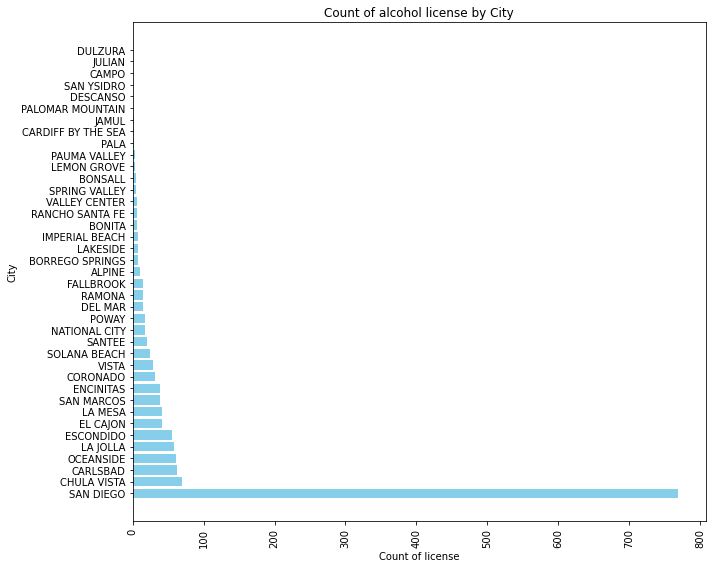

In [13]:
plt.figure(figsize=(10, 8))
plt.barh(nlicense.index, nlicense.values, color='skyblue')
plt.xlabel('Count of license')
plt.ylabel('City')
plt.title('Count of alcohol license by City')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Crime Dataset

This dataset describes crime incidents from 2016 to 2020, with demographic information for the victims. The file has one row per incident. The dataset is derived from data acquired for a PRA request and is processed to standardize geographic identifiers and racial categories.

In [14]:
crime_df =  pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/sdcrime_16_20_uniquecase.csv')
ucrcodes_df = pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/ucrcodes.csv')

Briefly browse dataset

In [15]:
crime_df.head(3)

,activitynumber,activitydate,year,agency,violationsection,violationtype,chargedescription,chargelevel,codeucr,crimecategory,personrole,race,age,sex,zipcode,censusblock,censustract,city,city.1
0,'01600014',2016-01-01 00:00:00,2016,NATIONAL CITY,10851,VC,TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT,FELONY,7A0,Vehicle Theft,VICTIM,OTHER,NaN,FEMALE,91950.0,'02000','022000',NATIONAL CITY,NATIONAL CITY
1,'16000042',2016-01-01 00:00:00,2016,SAN DIEGO,459,PC,BURGLARY/UNSPECIFIED,FELONY,5A6,Non Res Burglary,NaN,NaN,NaN,NaN,92109.0,'20000','007907',SAN DIEGO,SAN DIEGO
2,'16005661',2016-01-01 00:00:00,2016,SAN DIEGO,488,PC,PETTY THEFT,MISDEMEANOR,6DG,Larceny < $400,VICTIM/WITNESS,HISPANIC,74.0,MALE,92115.0,'20230','002902',SAN DIEGO,SAN DIEGO


In [16]:
crime_df.columns

Index(['activitynumber', 'activitydate', 'year', 'agency', 'violationsection',
       'violationtype', 'chargedescription', 'chargelevel', 'codeucr',
       'crimecategory', 'personrole', 'race', 'age', 'sex', 'zipcode',
       'censusblock', 'censustract', 'city', 'city.1'],
      dtype='object')

## Data Cleaning

1. clean columns: city, zipcode

In [17]:
# keep one of them is enough
(crime_df['city'] == crime_df['city.1']).all()

True

In [18]:
# drop all rows that containing nan in zipcode
crime_df = crime_df.dropna(subset=['zipcode'])

# convert zipcode type into int64
crime_df.loc[:, 'zipcode'] = crime_df['zipcode'].astype(int)

# filter df only include sd cities
crime_df = crime_df[crime_df['zipcode'].isin(zipcode_arr)]

# convert datatype of zipcode
crime_df['zipcode'] = crime_df['zipcode'].astype(int)

In [19]:
crime_df['city'] = crime_df['city'].str.strip()
crime_df['city'] = crime_df['city'].str.replace(r'\bUNINC\b|\bUNIN\b', '', regex=True)
crime_df['city'] = crime_df['city'].replace({'SAM DIEGO': 'SAN DIEGO', 'SAN SIEGO': 'SAN DIEGO',
                                             '5310 LA MESA': 'LA MESA', 'LAMESA': 'LA MESA',
                                             '92013': 'CARLSBAD', 'SPING VALLEY': 'SPRING VALLEY',
                                             'SAN YSABEL': 'SANTA YSABEL'})

crime_df = crime_df[(crime_df['city'] != 'CN') & (crime_df['city'] != 'SD COUNTY')]

2. Change activitydate data format, extract time only, create binary variable

In [20]:
crime_df['activitydate'] = pd.to_datetime(crime_df['activitydate'])

([<matplotlib.axis.XTick at 0x7f743cdecb50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

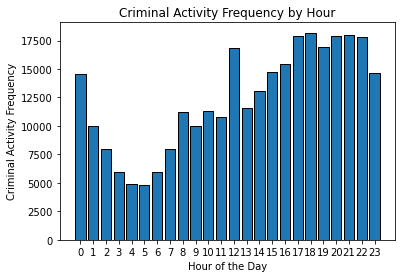

In [21]:
freq_ser = crime_df.groupby(crime_df['activitydate'].dt.hour).size()

plt.bar(x=freq_ser.index, height=freq_ser.values, edgecolor='black')
plt.title('Criminal Activity Frequency by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Criminal Activity Frequency')
plt.xticks(freq_ser.index)

We may notice that the frequency of criminal activity changes in a day, observing that high rates of criminal activity in the afternoon through evening hours, with crime rates dropping during the night. Thus, we create an `afternoon_till_eve` column by defining `activitydate` happened in the afternoon through evening hours(12:00am-12:00pm) as 1, other wise as 0.

In [22]:
hours = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]
crime_df['afternoon_till_eve'] = crime_df['activitydate'].dt.hour.isin(hours)
crime_df['afternoon_till_eve'] = crime_df['afternoon_till_eve'].astype(int)

3. select columns

**select `afternoon_till_eve` as confounding variable**
* activitydate: the specific report time
* bi_frequency: happened in high frequency time or low frequency time
* violationtype: violent or property

* sex: female or male
* age: young or old

In [23]:
sub_crime = crime_df[['activitydate', 'afternoon_till_eve', 'violationtype', 'crimecategory', 'zipcode', 'city']]

In [24]:
sub_crime

,activitydate,afternoon_till_eve,violationtype,crimecategory,zipcode,city
0,2016-01-01 00:00:00,1,VC,Vehicle Theft,91950,NATIONAL CITY
1,2016-01-01 00:00:00,1,PC,Non Res Burglary,92109,SAN DIEGO
2,2016-01-01 00:00:00,1,PC,Larceny < $400,92115,SAN DIEGO
3,2016-01-01 00:00:00,1,PC,Larceny >= $400,92109,SAN DIEGO
5,2016-01-01 00:00:00,1,PC,Larceny >= $400,92126,SAN DIEGO
...,...,...,...,...,...,...
312084,2020-07-31 23:00:00,1,VC,Vehicle Theft,91945,LEMON GROVE
312085,2020-07-31 23:00:00,1,VC,Vehicle Theft,92114,SAN DIEGO
312086,2020-07-31 23:00:00,1,VC,Vehicle Theft,92108,SAN DIEGO
312087,2020-07-31 23:23:00,1,PC,Aggravated Assault,92028,FALLBROOK


4. Aggregate based on `city` and `afternoon_till_eve`

In [25]:
ncrime = (sub_crime.groupby(['city', 'afternoon_till_eve'])
          ['activitydate']
          .count()
          .to_frame()
          .reset_index()
          .rename(columns={'activitydate': 'crime_count'}))
ncrime

,city,afternoon_till_eve,crime_count
0,4S RANCH,0,186
1,4S RANCH,1,481
2,ALPINE,0,371
3,ALPINE,1,855
4,BONITA,0,276
...,...,...,...
117,VISTA,1,5787
118,VISTA,0,324
119,VISTA,1,819
120,WARNER SPRINGS,0,21


5. Merge license data with crime data

In [26]:
df_license = nlicense.to_frame(name='license_count')

# merge with inner join
merged_df = pd.merge(df_license, ncrime, left_index=True, right_on='city', how='inner').reset_index(drop = True)
merged_df = merged_df[['city', 'license_count', 'crime_count', 'afternoon_till_eve']]
merged_df 

,city,license_count,crime_count,afternoon_till_eve
0,SAN DIEGO,769,48990,0
1,SAN DIEGO,769,106319,1
2,CHULA VISTA,70,6266,0
3,CHULA VISTA,70,16423,1
4,CARLSBAD,62,1590,0
...,...,...,...,...
73,CAMPO,1,147,1
74,JULIAN,1,59,0
75,JULIAN,1,128,1
76,DULZURA,1,28,0


6. Get density per capita data

In order to calculate the alcohol density per capita, and criminal activity density per capita, we access the population data from the following source:
https://data.census.gov/table/DECENNIALPL2020.P1?g=160XX00US0611194,0613392,0616378,0618506,0621712,0622678,0622804,0636294,0640004,0650398,0653322,0658520,0666000,0668196,0670224,0672506,0682996_8610000US92093_880XX00US9203706073&tp=true

In [27]:
cities = [
    'CARLSBAD',
    'CHULA VISTA',
    'CORONADO',
    'DEL MAR',
    'EL CAJON',
    'ENCINITAS',
    'ESCONDIDO',
    'IMPERIAL BEACH',
#     'LA JOLLA',
    'LA MESA',
    'NATIONAL CITY',
    'OCEANSIDE',
    'POWAY',
    'SAN DIEGO',
    'SAN MARCOS',
    'SANTEE',
    'SOLANA BEACH',
    'VISTA'
]

In [28]:
# pop = pd.read_csv("population.csv")
# population = pop.dropna().reset_index(drop=True)
# population['Total:'] = population['Total:'].str.replace(',', '').astype(int)
# population.rename(columns={'Label (Grouping)': 'city', 'Total:': 'population'}, inplace=True)
# population['city'] = cities

# population.head()

In [29]:
pp = pd.read_csv("population_poverty.csv")
population = pp[['city', 'population', 'poverty']]
population['poverty_rate'] = pp['poverty']/pp['population']
population['city'] = cities

population.head()

/tmp/ipykernel_1843/3540533265.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population['poverty_rate'] = pp['poverty']/pp['population']
/tmp/ipykernel_1843/3540533265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population['city'] = cities


,city,population,poverty,poverty_rate
0,CARLSBAD,114204,7858,0.068807
1,CHULA VISTA,274000,24068,0.087839
2,CORONADO,15430,900,0.058328
3,DEL MAR,3943,66,0.016739
4,EL CAJON,103824,19586,0.188646


7. Merge together to get finalized dataframe

In [30]:
merged_df = pd.merge(merged_df, population, on='city')
merged_df

,city,license_count,crime_count,afternoon_till_eve,population,poverty,poverty_rate
0,SAN DIEGO,769,48990,0,1343744,152819,0.113726
1,SAN DIEGO,769,106319,1,1343744,152819,0.113726
2,CHULA VISTA,70,6266,0,274000,24068,0.087839
3,CHULA VISTA,70,16423,1,274000,24068,0.087839
4,CARLSBAD,62,1590,0,114204,7858,0.068807
5,CARLSBAD,62,4117,1,114204,7858,0.068807
6,OCEANSIDE,61,3546,0,172603,15875,0.091974
7,OCEANSIDE,61,8498,1,172603,15875,0.091974
8,ESCONDIDO,55,1805,0,149548,19796,0.132372
9,ESCONDIDO,55,4375,1,149548,19796,0.132372


In [31]:
merged_df['alcohol_density'] = merged_df['license_count'] / merged_df['population']
merged_df['crime_density'] = merged_df['crime_count'] / merged_df['population']

In [32]:
merged_df.head()

,city,license_count,crime_count,afternoon_till_eve,population,poverty,poverty_rate,alcohol_density,crime_density
0,SAN DIEGO,769,48990,0,1343744,152819,0.113726,0.000572,0.036458
1,SAN DIEGO,769,106319,1,1343744,152819,0.113726,0.000572,0.079121
2,CHULA VISTA,70,6266,0,274000,24068,0.087839,0.000255,0.022869
3,CHULA VISTA,70,16423,1,274000,24068,0.087839,0.000255,0.059938
4,CARLSBAD,62,1590,0,114204,7858,0.068807,0.000543,0.013922


In [33]:
merged_df.to_csv('merged_df.csv', index=False)

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34 non-null     object 
 1   license_count       34 non-null     int64  
 2   crime_count         34 non-null     int64  
 3   afternoon_till_eve  34 non-null     int64  
 4   population          34 non-null     int64  
 5   poverty             34 non-null     int64  
 6   poverty_rate        34 non-null     float64
 7   alcohol_density     34 non-null     float64
 8   crime_density       34 non-null     float64
dtypes: float64(3), int64(5), object(1)
memory usage: 2.5+ KB


## EDA

**Univariate Analysis**

In the univariate analysis, we would analyze the distribution of alcohol_density and the distribution of crime_density separately.

Firstly, let's check the descriptive statistics of two variables.

In [35]:
merged_df.describe()

,license_count,crime_count,afternoon_till_eve,population,poverty,poverty_rate,alcohol_density,crime_density
count,34.000000,34.000000,34.000000,3.400000e+01,34.000000,34.000000,34.000000,34.000000
mean,78.823529,7281.411765,0.500000,1.581645e+05,17184.176471,0.096390,0.000798,0.039184
std,176.049661,19443.344690,0.507519,3.081356e+05,35140.066208,0.042005,0.000923,0.026744
min,7.000000,102.000000,0.000000,3.943000e+03,66.000000,0.016739,0.000255,0.006610
25%,21.000000,1183.750000,0.000000,4.824700e+04,3997.000000,0.068807,0.000352,0.020609
50%,38.000000,1975.500000,0.500000,6.154000e+04,7761.000000,0.091974,0.000405,0.031204
75%,55.000000,4013.750000,1.000000,1.142040e+05,15875.000000,0.116819,0.000617,0.052654
max,769.000000,106319.000000,1.000000,1.343744e+06,152819.000000,0.188646,0.003804,0.142531


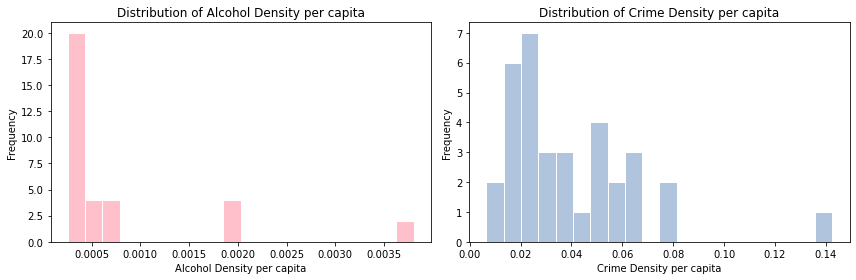

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

merged_df['alcohol_density'].plot(kind='hist', bins=20, ax=axs[0], color='pink', edgecolor='white')
axs[0].set_title('Distribution of Alcohol Density per capita')
axs[0].set_xlabel('Alcohol Density per capita')

merged_df['crime_density'].plot(kind='hist', bins=20, ax=axs[1], color='lightsteelblue', edgecolor='white')
axs[1].set_title('Distribution of Crime Density per capita')
axs[1].set_xlabel('Crime Density per capita')

plt.tight_layout()
plt.show()

In [37]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# merged_df['alcohol_density'].plot(kind='box', vert = False, ax=axs[0], color='pink')
# axs[0].set_title('Boxplot of Alcohol Density')
# axs[0].set_xlabel('Alcohol Density per capita')

# merged_df['crime_density'].plot(kind='box', vert = False, ax=axs[1], color='lightsteelblue')
# axs[1].set_title('Boxplot of Crime Density')
# axs[1].set_xlabel('Crime Density per capita')

# plt.tight_layout()
# plt.show()

From plot above, we may notice that alcohol_density is strongly right skewed, and we may need to perform square transformation to it. Also, there are outliers existed in both distributions and need to be removed.

* remove outliers

In [38]:
# Q1_alcohol = merged_df['alcohol_density'].quantile(0.25)
# Q3_alcohol = merged_df['alcohol_density'].quantile(0.75)
# IQR_alcohol = Q3_alcohol - Q1_alcohol

# lower_bound_alcohol = Q1_alcohol - 1.5 * IQR_alcohol
# upper_bound_alcohol = Q3_alcohol + 1.5 * IQR_alcohol

# Q1_crime = merged_df['crime_density'].quantile(0.25)
# Q3_crime = merged_df['crime_density'].quantile(0.75)
# IQR_crime = Q3_crime - Q1_crime

# lower_bound_crime = Q1_crime - 1.5 * IQR_crime
# upper_bound_crime = Q3_crime + 1.5 * IQR_crime

# merged_df = merged_df[
#     (merged_df['alcohol_density'] >= lower_bound_alcohol) &
#     (merged_df['alcohol_density'] <= upper_bound_alcohol) &
#     (merged_df['crime_density'] >= lower_bound_crime) &
#     (merged_df['crime_density'] <= upper_bound_crime)
# ]

* apply log transformation

In [39]:
merged_df['log_alcohol_density'] = merged_df['alcohol_density'].apply(np.log)

After transformed, the distribution is relatively normal distributed.

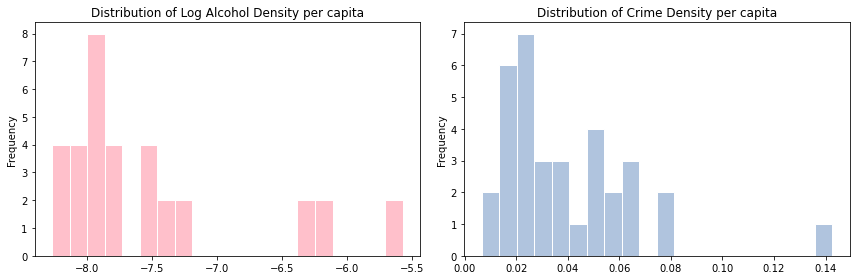

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

merged_df['log_alcohol_density'].plot(kind='hist', bins=20, ax=axs[0], color='pink', edgecolor='white')
axs[0].set_title('Distribution of Log Alcohol Density per capita')

merged_df['crime_density'].plot(kind='hist', bins=20, ax=axs[1], color='lightsteelblue', edgecolor='white')
axs[1].set_title('Distribution of Crime Density per capita')

plt.tight_layout()
plt.show()

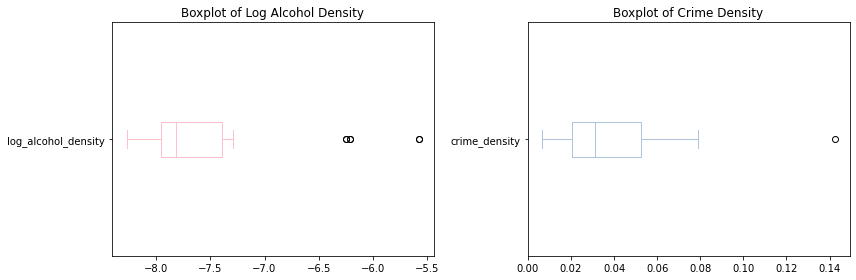

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

merged_df['log_alcohol_density'].plot(kind='box', vert = False, ax=axs[0], color='pink')
axs[0].set_title('Boxplot of Log Alcohol Density')

merged_df['crime_density'].plot(kind='box', vert = False, ax=axs[1], color='lightsteelblue')
axs[1].set_title('Boxplot of Crime Density')

plt.tight_layout()
plt.show()

**Bivariate Analysis**

explore relationship between alcohol_density and crime_density

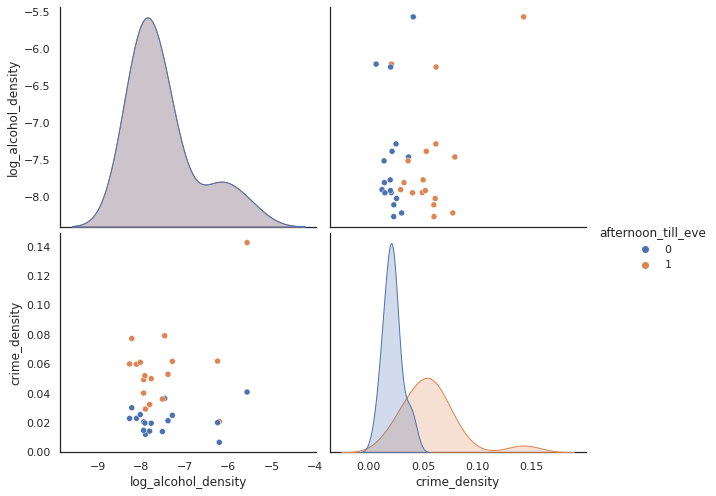

In [42]:
sns.set(style="white")
sns.pairplot(merged_df[['log_alcohol_density', 'crime_density', 'afternoon_till_eve']], hue = 'afternoon_till_eve', kind = 'scatter', height=3.5, aspect=1.2)

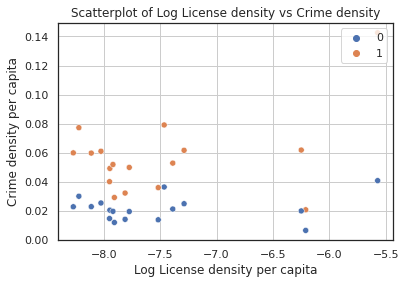

In [43]:
sns.scatterplot(data=merged_df, x='log_alcohol_density', y='crime_density', hue='afternoon_till_eve')

plt.xlabel('Log License density per capita')
plt.ylabel('Crime density per capita')
plt.title('Scatterplot of Log License density vs Crime density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

## Inferential Analysis: OLS

Even though the relationship is not apparent in scatterplot visualization, it is necessary to assess the results of a linear regression to determine whether there is a statistically significant relationship between log alcohol density and crime desntiy per capita.

### model

In [44]:
full_model = smf.ols('crime_density ~ alcohol_density + poverty_rate', data=merged_df).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:          crime_density   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.229
Date:                Fri, 31 May 2024   Prob (F-statistic):              0.125
Time:                        22:14:33   Log-Likelihood:                 77.677
No. Observations:                  34   AIC:                            -149.4
Df Residuals:                      31   BIC:                            -144.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0233      0.018     

In [45]:
X = merged_df[['alcohol_density', 'poverty_rate']]

# Add a constant term for the intercept
X = sm.add_constant(X)

# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

           feature        VIF
0            const  16.396360
1  alcohol_density   1.737795
2     poverty_rate   1.737795


In [46]:
correlation_matrix = merged_df[['alcohol_density', 'poverty_rate']].corr()
print(correlation_matrix)

                 alcohol_density  poverty_rate
alcohol_density         1.000000     -0.651581
poverty_rate           -0.651581      1.000000


Explanation:


1. When `log_alcohol_density` is zero and `afternoon_till_eve` is 0 (indicating not in the afternoon till evening period), the expected value of crime_density is 0.0901. This is the baseline level of crime_density.

2. For each unit increase in `log_alcohol_density`, `crime_density` is expected to increase by 0.0091, holding `afternoon_till_eve` constant. This indicates a positive relationship between alcohol density and crime density, although the relationship is only marginally significant.

3. When `afternoon_till_eve` changes from 0 to 1 (indicating the period transit from morning to afternoon till evening), `crime_density` is expected to increase by 0.0346, holding `log_alcohol_density` constant. This suggests that crime density is significantly higher during the afternoon till evening period compared to other times.

4. R-squared: 0.498: This indicates that approximately 50% of the variability in crime_density can be explained by the model.

### Diagnostics: check OLS assumptions

1. Linearity

Since residual plot show random scattering around zero for different values of the independent variable, thus the linearity assumption holds.

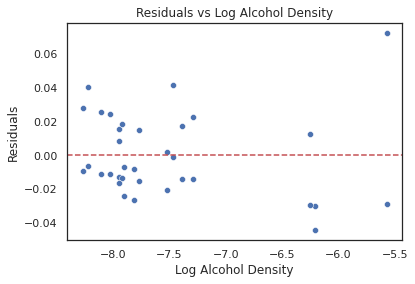

In [47]:
merged_df['residuals'] = full_model.resid

sns.scatterplot(data=merged_df, x='log_alcohol_density', y='residuals')
plt.title('Residuals vs Log Alcohol Density')
plt.xlabel('Log Alcohol Density')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--') 
plt.show()

2. **Normality** <br>

This Q-Q plot with points closely following the diagonal line indicates that the data is likely normally distributed.

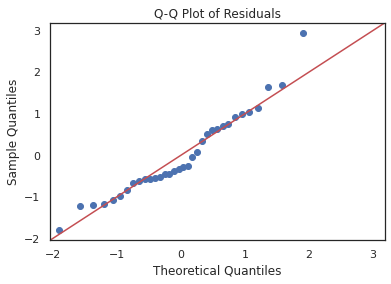

In [48]:
residuals = standardize(full_model.resid)
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

3. **Heteroscedasticity** <br>

Heteroscedasticity occurs when the variance of the errors in a regression model is not constant across observations. The identical assumption on the $\epsilon_i$ requires that the errors have constant variance. This can be checked by plotting the residuals against the predicted values of $y$. The residual plot does not show strong pattern, indicating homoscedasticity (constant variance of errors), and therefore the assumption holds.

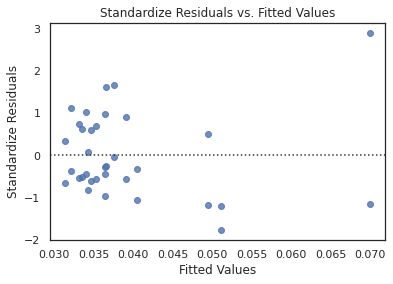

In [49]:
fitted_values = full_model.fittedvalues

sns.residplot(x=fitted_values, y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Standardize Residuals')
plt.title('Standardize Residuals vs. Fitted Values')
plt.show()

4. **Independence** <br>
The assumption of independence, which means that the residuals (errors) are independent of each other, appears to be violated. The Durbin-Watson statistic of 1.426 suggests some autocorrelation in the residuals, indicating that the independence assumption may not be fully satisfied. Ideally, the Durbin-Watson value should be close to 2 to indicate no autocorrelation.

The independence assumption on the $\epsilon_i$ requires that the errors are all independent. This can be checked by plotting the ACF functions for the residuals. We can see  one significant spike outside the confidence bands, this indicates autocorrelation and hence a potential **violation** of the independence assumption.

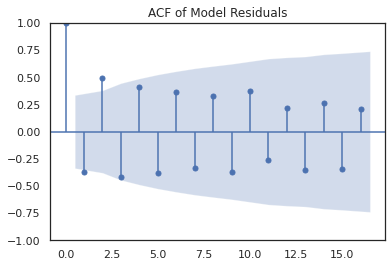

In [50]:
plot_acf(residuals)
plt.title('ACF of Model Residuals')
plt.show()

### Hypothesis Test

We apply a **permutation test** to explore the statistical significant relationship between the criminal event happening time and crime density across different cities in San Diego.

For this analysis, we will categorize crime based on the criminal activity time. We define a crime as "afternoon_till_eve" crime if it happened during the time at afternoon through evening. We will utilize a permutation test to assess the differences in average crime density between "afternoon_till_eve" crime and non-"afternoon_till_eve" crime events.

**Null Hypothesis (H0)**:
Every city has an identical crime density, regardless of the criminal event happening time.

**Alternative Hypothesis (H1)**:
Areas characterized by "afternoon_till_eve" are anticipated to have a higher crime density. This expectation is grounded in the hypothesis that criminal activities are more likely to occur during the afternoon and evening hours due to increased human activity and social interactions during these times, leading to more opportunities for crimes to be committed.

**Test statistic**: Difference in average crime density.

**Significant level**: 0.05

We opt for a **one-sided test** because it is consistent with our assumption that crime density is higher during the afternoon to evening period.

In [51]:
hypo_df = merged_df.copy()

def calculate_diff_in_means(data, group_col, value_col):
    group1 = data[data[group_col] == 1][value_col]
    group2 = data[data[group_col] == 0][value_col]
    return group1.mean() - group2.mean()

observed_diff = calculate_diff_in_means(hypo_df, 'afternoon_till_eve', 'crime_density')

num_permutations = 10000
perm_diffs = np.zeros(num_permutations)

for i in range(num_permutations):
    # shuffle the 'afternoon_till_eve' labels
    shuffled_labels = np.random.permutation(hypo_df['afternoon_till_eve'])
    shuffled_data = hypo_df.copy()
    shuffled_data['shuffled_labels'] = shuffled_labels
    
    perm_diffs[i] = calculate_diff_in_means(shuffled_data, 'shuffled_labels', 'crime_density')

p_value = np.mean(perm_diffs >= observed_diff)
print(f'Observed difference in means: {observed_diff}')
print(f'One-tailed p-value: {p_value}')

alpha = 0.05 
if p_value < alpha:
    decision = "reject the null hypothesis"
else:
    decision = "fail to reject the null hypothesis"
print(f'Decision: We {decision}.')

Observed difference in means: 0.03525338754648201
One-tailed p-value: 0.0
Decision: We reject the null hypothesis.


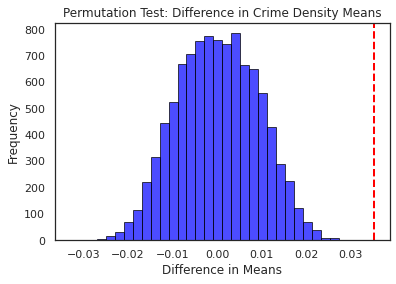

In [52]:
plt.hist(perm_diffs, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.title('Permutation Test: Difference in Crime Density Means')
plt.show()

In [53]:
# Step 1: Extract the list of cities from merged_data
cities = merged_df['city'].unique()

# Step 2: Filter sub_crime and sub_alcohol to include only rows where the city is in the list of cities from merged_data
filtered_crime = sub_crime[sub_crime['city'].isin(cities)]
filtered_alcohol = sub_alcohol[sub_alcohol['Prem City'].isin(cities)]

# Step 3: Convert zip codes to integers
filtered_crime['zipcode'] = filtered_crime['zipcode'].astype(int)
filtered_alcohol['Prem Zip'] = filtered_alcohol['Prem Zip'].astype(int)

# Step 4: Extract unique zip codes and their corresponding cities from the filtered dataframes
unique_crime_zipcodes = filtered_crime[['zipcode', 'city']].drop_duplicates()
unique_alcohol_zipcodes = filtered_alcohol[['Prem Zip', 'Prem City']].drop_duplicates()

# Step 5: Rename columns to have consistent names for merging
unique_alcohol_zipcodes = unique_alcohol_zipcodes.rename(columns={'Prem Zip': 'zipcode', 'Prem City': 'city'})

# Step 6: Combine the unique zip codes and their corresponding cities, and remove duplicates
all_unique_zipcodes = pd.concat([unique_crime_zipcodes, unique_alcohol_zipcodes]).drop_duplicates()


all_unique_zipcodes

/tmp/ipykernel_1843/778073358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crime['zipcode'] = filtered_crime['zipcode'].astype(int)
/tmp/ipykernel_1843/778073358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_alcohol['Prem Zip'] = filtered_alcohol['Prem Zip'].astype(int)


,zipcode,city
0,91950,NATIONAL CITY
1,92109,SAN DIEGO
2,92115,SAN DIEGO
5,92126,SAN DIEGO
6,92037,SAN DIEGO
...,...,...
301587,92102,CHULA VISTA
305473,92023,CARLSBAD
68,92011,CARLSBAD
436,92081,VISTA
